In [82]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf
from datetime import datetime
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import math
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')

In [83]:
# symbol = input(str("輸入股票代碼"))
# data = input(str("輸入開始日期(yyyy-mm-dd)"))
symbol = "SPY"
data = "2020-01-01"
df = yf.download(symbol,data)

df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [84]:
# 時間範圍內 K線圖
fig = go.Figure(go.Candlestick(x=df.index,
  open=df['Open'],
  high=df['High'],
  low=df['Low'],
  close=df['Close']))
fig.show()

#### 定義 **SuperTrend**

In [85]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    #df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
            
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        # 根據趨勢方向刪除波段以進行可視化
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)

#### 定義 DEMA

In [86]:
#Create a function to calculate the Double Exponential Moving Average (DEMA)
def DEMA(data, time_period, column):
  #Calculate the Exponential Moving Average for some time_period (in days)
  EMA = data[column].ewm(span=time_period, adjust=False).mean()
  #Calculate the DEMA
  DEMA = 2*EMA - EMA.ewm(span=time_period, adjust=False).mean()
  return DEMA

In [87]:
## 使用ST
atr_period = 34
atr_multiplier = 3.0
ST_day = 144 
LT_day = 169 

supertrend = Supertrend(df, atr_period, atr_multiplier)
df = df.join(supertrend)

df['DEMA_short'] = DEMA(df, ST_day, 'Close') #Store the short term DEMA 
df['DEMA_long'] = DEMA(df, LT_day, 'Close') #Store the long term DEMA 

df

,Open,High,Low,Close,Volume,Supertrend,Final Lowerband,Final Upperband,DEMA_short,DEMA_long
Date,,,,,,,,,,
2019-12-31,320.529999,322.130005,320.149994,321.859985,57077300,True,NaN,NaN,321.859985,321.859985
2020-01-02,323.540009,324.890015,322.529999,324.869995,59151200,True,NaN,NaN,321.942447,321.930393
2020-01-03,321.160004,323.640015,321.100006,322.410004,77709700,True,NaN,NaN,321.955814,321.942018
2020-01-06,320.489990,323.730011,320.359985,323.640015,55653900,True,NaN,NaN,322.002597,321.982207
2020-01-07,323.019989,323.540009,322.239990,322.730011,40496400,True,NaN,NaN,322.023480,322.000400
...,...,...,...,...,...,...,...,...,...,...
2022-09-12,408.779999,411.730011,408.459991,410.970001,69256300,False,NaN,413.226732,400.908936,404.510031
2022-09-13,401.829987,403.100006,391.920013,393.100006,122947100,False,NaN,413.226732,400.532932,404.125581
2022-09-14,394.470001,396.200012,391.119995,394.600006,85023700,False,NaN,413.226732,400.206908,403.783684


In [88]:

# initial condition
# equity = investment
# commission = 5
# share = 0

in_position = False #倉位為 空
is_uptrend = df['Supertrend']


buy_list = [] #Create a list to store the price at which to buy
sell_list = [] #Create a list to store the price at which to sell
flag =  False #Create a flag to determine when the indicators cross

for i in range(0,len(df)):
    if df['Final Lowerband'][i] < df['DEMA_short'][i] : # ST位於DEMA區間下
        if df['Final Lowerband'][i] < df['DEMA_long'][i] and in_position == False:
            buy_list.append(df['Close'][i])
            sell_list.append(np.nan)
            in_position = True

    elif  df['Final Upperband'][i] < df['DEMA_short'][i] : # ST位於DEMA區間上
            if df['Final Upperband'][i] < df['DEMA_long'][i] and in_position == True:
                buy_list.append(np.nan)
                sell_list.append(df['Close'][i])
                in_position = False

    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)


In [89]:
# initial condition
investment = 100000
equity = investment
commission = 5
share = 0

in_position = False #倉位為 空
is_uptrend = df['Supertrend']

close = df['Close']
entry = []
exit = []

buy_list = [] #Create a list to store the price at which to buy
sell_list = [] #Create a list to store the price at which to sell
flag =  False #Create a flag to determine when the indicators cross

for i in range(2,len(df)):
    if df['Final Lowerband'][i] < df['DEMA_short'][i] : # ST位於DEMA區間下
        if df['Final Lowerband'][i] < df['DEMA_long'][i] and in_position == False:
            buy_list.append(df['Close'][i])
            sell_list.append(np.nan)
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
            print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
            

    elif  df['Final Upperband'][i] < df['DEMA_short'][i] : # ST位於DEMA區間上
            if df['Final Upperband'][i] < df['DEMA_long'][i] and in_position == True:
                buy_list.append(np.nan)
                sell_list.append(df['Close'][i])
                equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
            print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
            

    else:
        equity += share * close[i] - commission
        buy_list.append(np.nan)
        sell_list.append(np.nan)

earning = equity - investment #盈餘
roi = round(earning/investment*100,2) #投資報酬率
print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')

Sell at 311.5 on 2020/02/26
Sell at 297.51 on 2020/02/27
Sell at 296.26 on 2020/02/28
Buy 300 shares at 309.09 on 2020/03/02
Sell at 274.23 on 2020/03/09
Sell at 288.42 on 2020/03/10
Sell at 274.36 on 2020/03/11
Sell at 248.11 on 2020/03/12
Sell at 269.32 on 2020/03/13
Sell at 239.85 on 2020/03/16
Sell at 252.8 on 2020/03/17
Sell at 240.0 on 2020/03/18
Sell at 240.51 on 2020/03/19
Sell at 228.8 on 2020/03/20
Sell at 222.95 on 2020/03/23
Sell at 243.15 on 2020/03/24
Sell at 246.79 on 2020/03/25
Buy 300 shares at 261.2 on 2020/03/26
Sell at 434.04 on 2021/09/20
Sell at 433.63 on 2021/09/21
Sell at 437.86 on 2021/09/22
Sell at 443.18 on 2021/09/23
Sell at 443.91 on 2021/09/24
Sell at 442.64 on 2021/09/27
Sell at 433.72 on 2021/09/28
Sell at 434.45 on 2021/09/29
Sell at 429.14 on 2021/09/30
Sell at 434.24 on 2021/10/01
Sell at 428.64 on 2021/10/04
Sell at 433.1 on 2021/10/05
Sell at 434.9 on 2021/10/06
Sell at 438.66 on 2021/10/07
Sell at 437.86 on 2021/10/08
Sell at 434.69 on 2021/10/11
S

#### plot

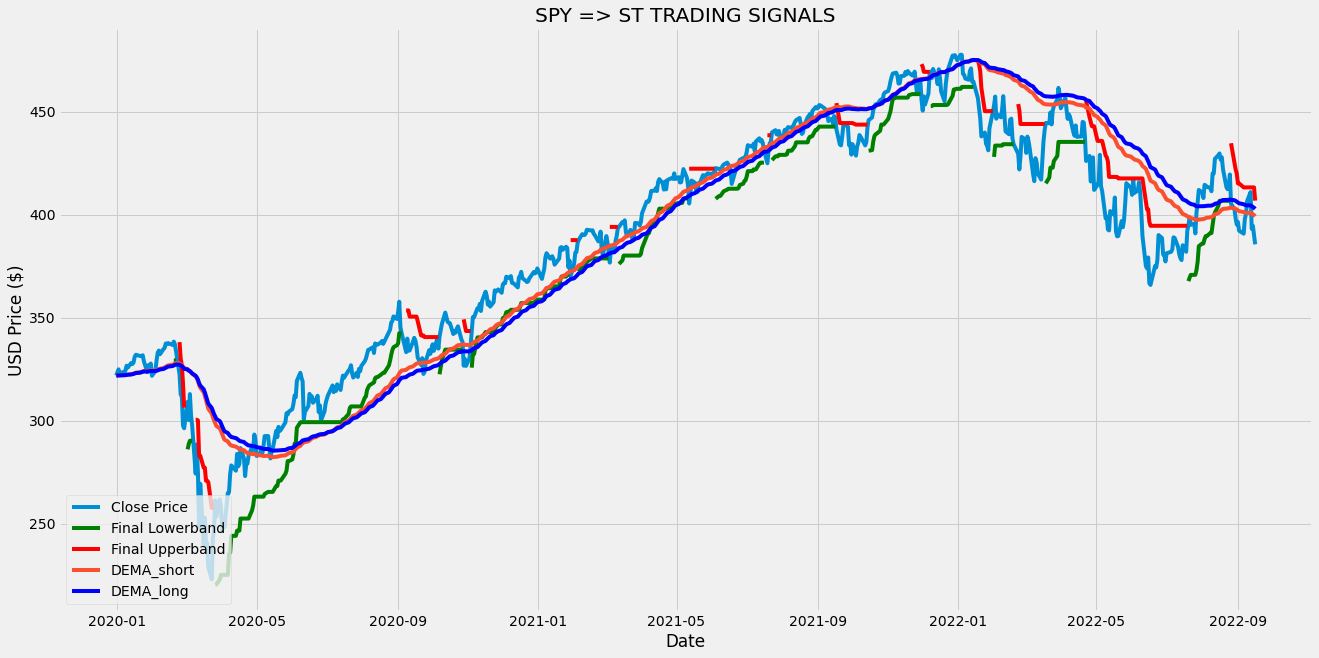

In [90]:
# visualization
plt.figure(figsize=(20,10))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'], 'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.plot(df['DEMA_short'],  label = 'DEMA_short')
plt.plot(df['DEMA_long'], 'b', label = 'DEMA_long')
plt.title(symbol + ' => ST TRADING SIGNALS')
plt.ylabel('USD Price ($)')
plt.xlabel('Date')
plt.legend(loc = 'lower left')
plt.show()


#### 2DEMA ST　主程式

In [91]:
def two_DEMA_with_supertred(data):
    is_uptrend = data['supertrend']
    close = data['Close']
    
    # initial condition
    in_position = False #倉位為 空
    # equity = investment
    commission = 5
    share = 0
    # entry = []
    # exit = []

    buy_list = [] #Create a list to store the price at which to buy
    sell_list = [] #Create a list to store the price at which to sell
    flag =  False #Create a flag to determine when the indicators cross
    
    for i in range(0,len(data)):
        if data['supertrend'][i] < data['DEMA_short'][i] and data['supertrend'][i] < data['DEMA_long']: # ST位於DEMA區間下
          if flag == False:
            buy_list.append(data['Close'][i])
            sell_list.append(np.nan)
            flag = True
             
        elif data['supertrend'][i] < data['DEMA_short'][i] and data['supertrend'][i] < data['DEMA_long']: # ST位於DEMA區間上
           if flag == True:
              buy_list.append(np.nan)
              sell_list.append(data['Close'][i])
              flag = False

        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)

    #Store the Buy and Sell signals in the data set
    data['Buy'] = buy_list
    data['Sell'] = sell_list

In [92]:
two_DEMA_with_supertred(df)

KeyError: 'supertrend'

In [ ]:
def DEMA_Strategy(data):
  buy_list = [] #Create a list to store the price at which to buy
  sell_list = [] #Create a list to store the price at which to sell
  flag =  False #Create a flag to determine when the indicators cross
  #Loop through the data
  for i in range(0,len(data)):
      #Check if the Short Term DEMA crosses above the Long Term DEMA
      if data['DEMA_short'][i]  > data['DEMA_long'][i] and flag == False:
          buy_list.append(data['Close'][i])
          sell_list.append(np.nan)
          flag = True
      #Check if the Short Term DEMA crosses below the Long Term DEMA    
      elif data['DEMA_short'][i]  < data['DEMA_long'][i] and flag == True:
          buy_list.append(np.nan)
          sell_list.append(data['Close'][i])
          flag = False
      else:#Else they didn't cross
          buy_list.append(np.nan)
          sell_list.append(np.nan)
  #Store the Buy and Sell signals in the data set
  data['Buy'] = buy_list
  data['Sell'] = sell_list

In [ ]:
#Run the Strategy to get the buy and sell signals
DEMA_Strategy(df)

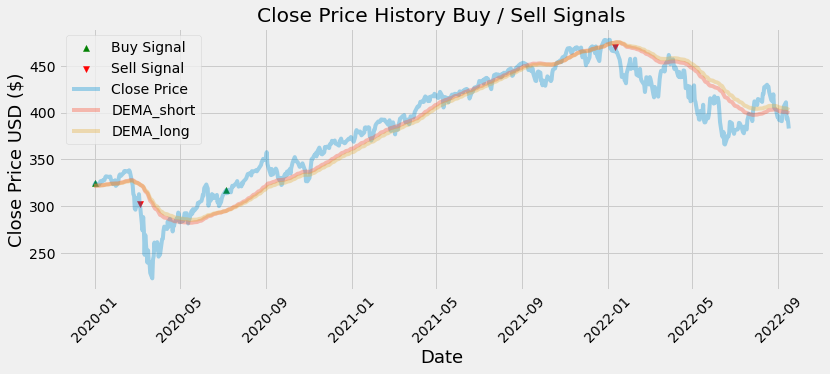

In [ ]:
# Visually Show The Stock Buy and Sell Signals
#Create and plot the graph
plt.figure(figsize=(12.2,4.5)) #width = 12.2in, height = 4.5
plt.scatter(df.index, df['Buy'], color = 'green', label='Buy Signal', marker = '^', alpha = 1) #Plot the buy signal
plt.scatter(df.index, df['Sell'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1) #Plot the sell signal
plt.plot( df['Close'],  label='Close Price', alpha = 0.35)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.plot( df['DEMA_short'],  label='DEMA_short', alpha = 0.35) #plot the Short Term DEMA
plt.plot( df['DEMA_long'],  label='DEMA_long', alpha = 0.35) #plot the Long Term DEMA
plt.xticks(rotation=45)#Rotate the dates 45 degrees
plt.title('Close Price History Buy / Sell Signals')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.legend( loc='upper left')
plt.show()

=======

In [ ]:
def backtest_supertrend(df, investment):
    is_uptrend = df['Supertrend']
    close = df['Close']
    
    # initial condition
    in_position = False #倉位為 空
    equity = investment
    commission = 5
    share = 0
    entry = []
    exit = []


    for i in range(2, len(df)):
        # if not in position & price is on uptrend -> buy
        # 沒有倉位 及 價格處於上升 => 買入
        if not in_position and is_uptrend[i]:
            share = math.floor(equity / close[i] / 100) * 100
            equity -= share * close[i]
            entry.append((i, close[i]))
            in_position = True
            print(f'Buy {share} shares at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
        

        # if in position & price is not on uptrend -> sell
        # 有倉位且價格低於上升趨勢 =>賣出
        elif in_position and not is_uptrend[i]:
            equity += share * close[i] - commission
            exit.append((i, close[i]))
            in_position = False
            print(f'Sell at {round(close[i],2)} on {df.index[i].strftime("%Y/%m/%d")}')
            
    # if still in position -> sell all share
    # 賣出所有倉位
    if in_position:
        equity += share * close[i] - commission
    
    earning = equity - investment #盈餘
    roi = round(earning/investment*100,2) #投資報酬率
    print(f'Earning from investing $100k is ${round(earning,2)} (ROI = {roi}%)')
    return entry, exit, equity

In [ ]:
entry, exit, roi = backtest_supertrend(df, 100000)

Buy 300 shares at 322.41 on 2020/01/03
Sell at 322.42 on 2020/02/24
Buy 300 shares at 309.09 on 2020/03/02
Sell at 274.23 on 2020/03/09
Buy 300 shares at 261.2 on 2020/03/26
Sell at 333.21 on 2020/09/08
Buy 300 shares at 340.76 on 2020/10/07
Sell at 326.66 on 2020/10/28
Buy 300 shares at 343.54 on 2020/11/04
Sell at 370.07 on 2021/01/29
Buy 200 shares at 387.71 on 2021/02/05
Sell at 376.7 on 2021/03/04
Buy 200 shares at 394.06 on 2021/03/12
Sell at 405.41 on 2021/05/12
Buy 200 shares at 422.6 on 2021/06/04
Sell at 424.97 on 2021/07/19
Buy 200 shares at 439.94 on 2021/07/23
Sell at 441.4 on 2021/09/17
Buy 200 shares at 445.87 on 2021/10/15
Sell at 455.56 on 2021/11/30
Buy 200 shares at 469.52 on 2021/12/08
Sell at 456.49 on 2022/01/18
Buy 200 shares at 452.95 on 2022/02/01
Sell at 429.57 on 2022/02/22
Buy 200 shares at 444.52 on 2022/03/18
Sell at 426.04 on 2022/04/22
Buy 200 shares at 394.77 on 2022/07/20
Sell at 405.31 on 2022/08/26
Earning from investing $100k is $8709.01 (ROI = 8.71

In [ ]:
def get_benchmark(start_date, investment_value):
    close = df['Close']
    benchmark = pd.DataFrame(np.diff(close)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/close[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)
investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('ST Strategy profit is {}% higher than the Benchmark Profit'.format(roi/100 - benchmark_profit_percentage), attrs = ['bold']))

Benchmark profit by investing $100k : 15947.1
Benchmark Profit percentage : 15%
ST Strategy profit is 1072.090069580078% higher than the Benchmark Profit


In [ ]:
import requests
url = 'https://www.slickcharts.com/sp500'
headers = {"User-Agent" : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'}

request = requests.get(url, headers = headers)

data = pd.read_html(request.text)[0]

# 欄位『Symbol』就是股票代碼
stock_list = data.Symbol

In [ ]:
# get the full stock list of S&P 500
#payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
#stock_list = payload[0]['Symbol'].values.tolist()
supertrend_stocks = []
# loop through each symbol
for symbol in stock_list:
    df = yf.download(symbol, start='2000-01-01', threads= False)
    if len(df) == 0: continue
    supertrend = Supertrend(df, atr_period, atr_multiplier)
    if not supertrend['Supertrend'][-2] and supertrend['Supertrend'][-1]:
        supertrend_stocks.append(symbol)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRK.B: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


KeyboardInterrupt: 

In [ ]:
supertrend_stocks

[]

In [ ]:
for s in supertrend_stocks:
    print(s, end = ', ')

In [ ]:
def find_optimal_parameter(df):
    # predefine several parameter sets
    atr_period = [7, 8, 9, 10, 12, 18, 24, 28, 30, 34, 40]
    atr_multiplier = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
    roi_list = []
    
    # for each period and multiplier, perform backtest
    for period, multiplier in [(x,y) for x in atr_period for y in atr_multiplier]:
        new_df = df
        supertrend = Supertrend(df, period, multiplier)
        new_df = df.join(supertrend)
        new_df = new_df[period:]
        entry, exit, roi = backtest_supertrend(new_df, 100000)
        roi_list.append((period, multiplier, roi))
    
    print(pd.DataFrame(roi_list, columns=['ATR_period','Multiplier','ROI']))
    
    # return the best parameter set
    return max(roi_list, key=lambda x:x[2])

df = yf.download('spy', start='2020-01-01')
optimal_param = find_optimal_parameter(df)
print(f'Best parameter set: ATR Period={optimal_param[0]}, Multiplier={optimal_param[1]}, ROI={optimal_param[2]}%')

[*********************100%***********************]  1 of 1 completed
Buy 300 shares at 327.45 on 2020/01/14
Sell at 328.77 on 2020/01/24
Buy 300 shares at 327.68 on 2020/01/30
Sell at 321.73 on 2020/01/31
Buy 200 shares at 329.06 on 2020/02/04
Sell at 333.48 on 2020/02/21
Buy 300 shares at 309.09 on 2020/03/02
Sell at 297.46 on 2020/03/06
Buy 300 shares at 243.15 on 2020/03/24
Sell at 273.04 on 2020/04/21
Buy 300 shares at 287.05 on 2020/04/27
Sell at 282.79 on 2020/05/01
Buy 300 shares at 292.44 on 2020/05/08
Sell at 281.6 on 2020/05/13
Buy 300 shares at 295.0 on 2020/05/18
Sell at 300.61 on 2020/06/11
Buy 300 shares at 312.96 on 2020/06/16
Sell at 304.09 on 2020/06/24
Buy 300 shares at 310.52 on 2020/07/01
Sell at 320.88 on 2020/07/24
Buy 300 shares at 325.12 on 2020/07/29
Sell at 345.39 on 2020/09/03
Buy 300 shares at 334.19 on 2020/09/28
Sell at 342.01 on 2020/10/19
Buy 300 shares at 336.03 on 2020/11/03
Sell at 364.66 on 2020/12/14
Buy 300 shares at 372.24 on 2020/12/17
Sell at 36